# AirBnb listings file modeling

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
from IPython.core.display import display, HTML
import pandas as pd
import warnings
import ast
warnings.filterwarnings('ignore')

%reload_ext autoreload
%autoreload 1
%matplotlib inline

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import os
import seaborn as sns
import pandas as pd
import math

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error as MSE

from imblearn.over_sampling import SMOTE

from Utils.UtilsGeoViz import *
from Utils.UtilsViz import *
from Utils.DataUtils import *

RANDOM_SEED = 42

In [3]:
# data_path = "C:\\Users\\sriharis\\OneDrive\\UChicago\\DataMining\\project\\NYData\\cleaned_with_nlp_listings.csv"
data_path = os.path.join(os.getcwd(), "../data/cleaned_listings.csv")
listings = pd.read_csv(data_path, index_col="id")
display(listings.shape)

(48855, 80)

### Plot the dstribution

Let's plot the percentile for price

Text(0, 0.5, 'Price')

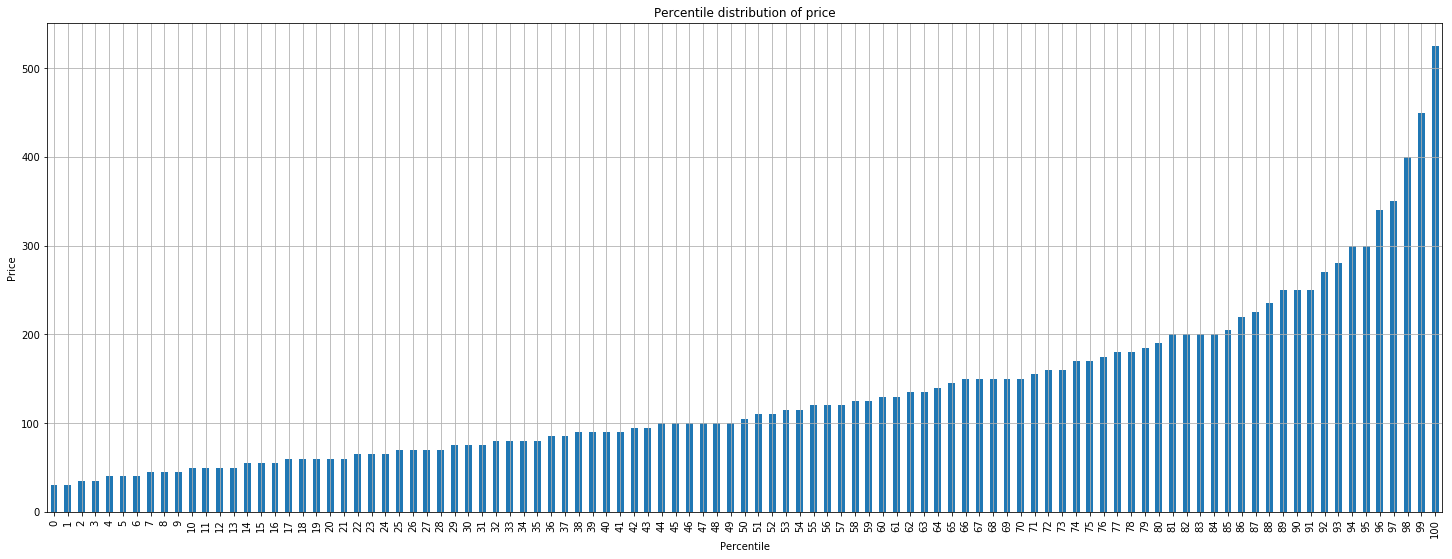

In [4]:
percentiles = list(range(0,101, 1))
price_percentile = {}
for p in percentiles:
    price_percentile[p] = np.percentile(listings['price'].values, p)

price_percentile = pd.DataFrame.from_dict(price_percentile, orient='index')
price_percentile.plot(kind='bar', figsize=(25,9), grid=True, legend=False)
plt.title("Percentile distribution of price")
plt.xlabel("Percentile")
plt.ylabel("Price")

In [6]:
# display(
#     price_percentile.iloc[PERCENTILE_CROP[0],:].values[0],
#     price_percentile.iloc[PERCENTILE_CROP[1],:].values[0],
# )

Considering that beyond the 99th percentile (approx. 650 USD) the data shoots up, we can consider value above it as outliers.

Similarly, we can remove everything below 1% percentile.

How many rows would we lose if we removed everything above 99 percentile?

In [7]:
# listings_filtered = listings[listings["price"] <= price_percentile.iloc[PERCENTILE_CROP[1],:].values[0]]
# listings_filtered = listings_filtered[listings_filtered["price"] >= price_percentile.iloc[PERCENTILE_CROP[0],:].values[0]]
# listings_filtered["price"].describe()

In [8]:
# 100 * (listings.shape[0] - listings_filtered.shape[0]) / listings.shape[0]

We lose less than 2% of rows upon dropping those outliers. Worth it.

In [9]:
# percentiles = list(range(0,101))
# price_percentile = {}
# for p in percentiles:
#     price_percentile[p] = np.percentile(listings_filtered['price'].values, p)

# price_percentile = pd.DataFrame.from_dict(price_percentile, orient='index')
# price_percentile.plot(kind='bar', figsize=(25,9), grid=True, legend=False)
# plt.title("Percentile distribution of price")
# plt.xlabel("Percentile")
# plt.ylabel("Price")

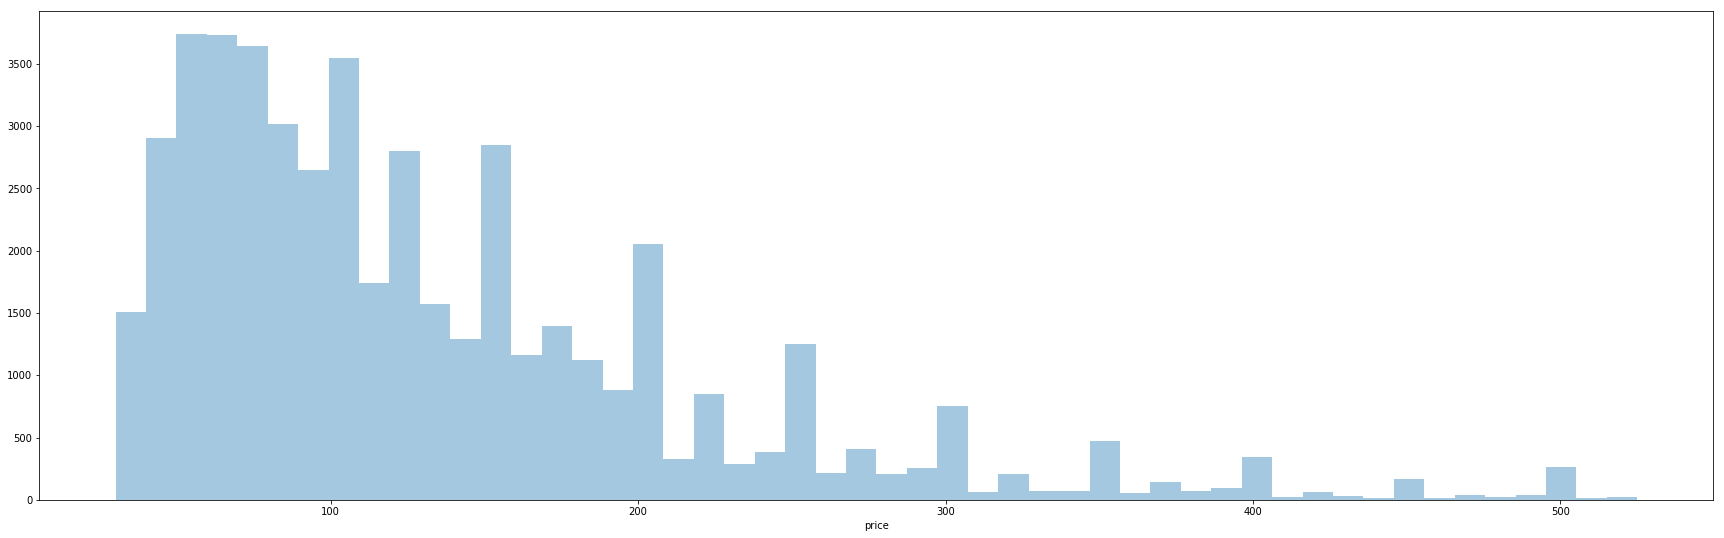

In [10]:
f, ax = plt.subplots(1,1,figsize=(30,9))
g = sns.distplot(listings["price"], kde=False, ax=ax)

## Rounding Prices 

For the sake of ease, what if we round the prices to the nearest multiple of 5?

In [11]:
base = 5
def roundto(row):
    return int(base * round(float(row)/base))
listings["price"] = listings["price"].apply(roundto)

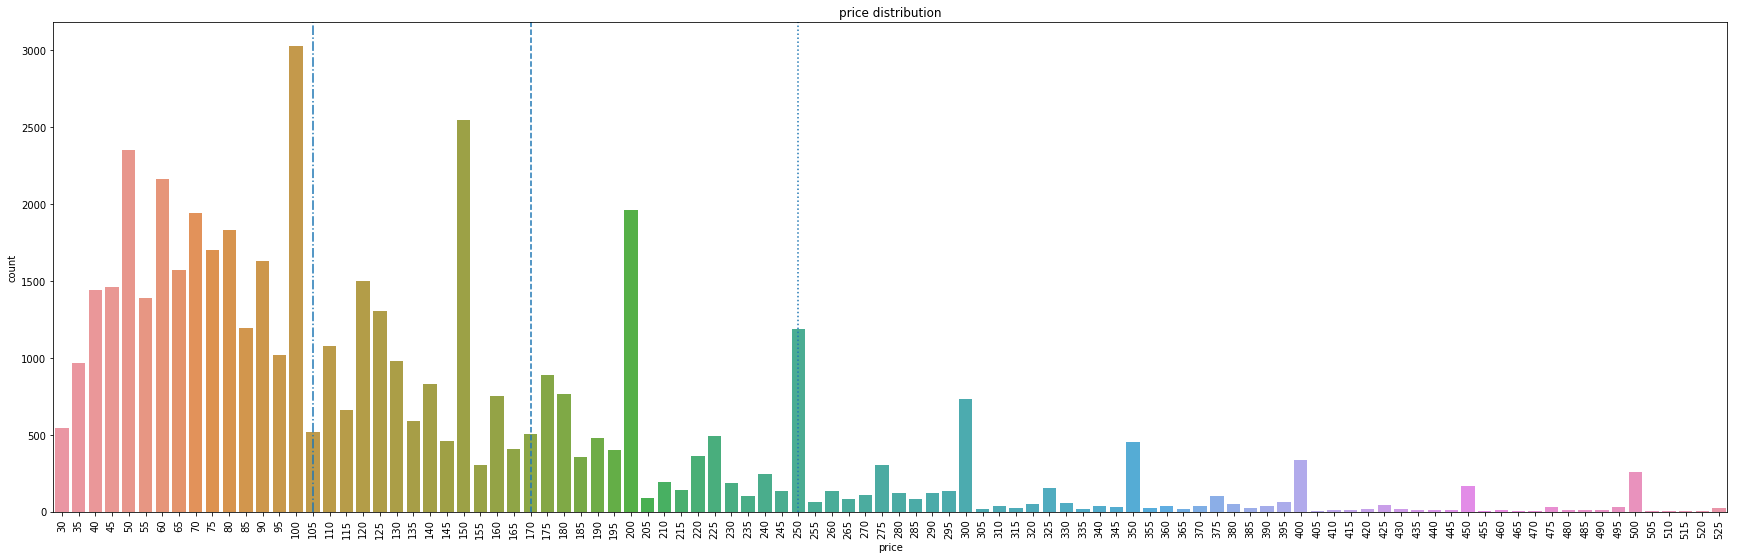

In [12]:
f, ax = plt.subplots(1,1,figsize=(30,9))
g = sns.countplot(x="price", data=listings, ax=ax)
t = g.set_xticklabels(g.get_xticklabels(), rotation=90)
t = g.set_title("price distribution")
median_idx = np.where(np.sort(listings["price"].unique())==listings["price"].median())
plt.axvline(x=median_idx, linestyle="-.")
percentile_75_idx = np.where(np.sort(listings["price"].unique())==price_percentile.iloc[75,:].values[0])
plt.axvline(x=percentile_75_idx, linestyle="--")
percentile_90_idx = np.where(np.sort(listings["price"].unique())==price_percentile.iloc[90,:].values[0])
plt.axvline(x=percentile_90_idx, linestyle=":")

## Preprocessing

In [13]:
ycol = ["price"]
xcol = [i for i in listings.columns if i not in ycol]
x = listings[xcol].values
y = listings[ycol].values

### 1. Standardisation

In [14]:
standard_scaler = StandardScaler()
x = standard_scaler.fit_transform(x)

### 2. Train test split

In [15]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=RANDOM_SEED)

### 3. Transformation

d:\softwares\python36\lib\site-packages\matplotlib\cbook\__init__.py:1725: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))
d:\softwares\python36\lib\site-packages\matplotlib\cbook\__init__.py:1725: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


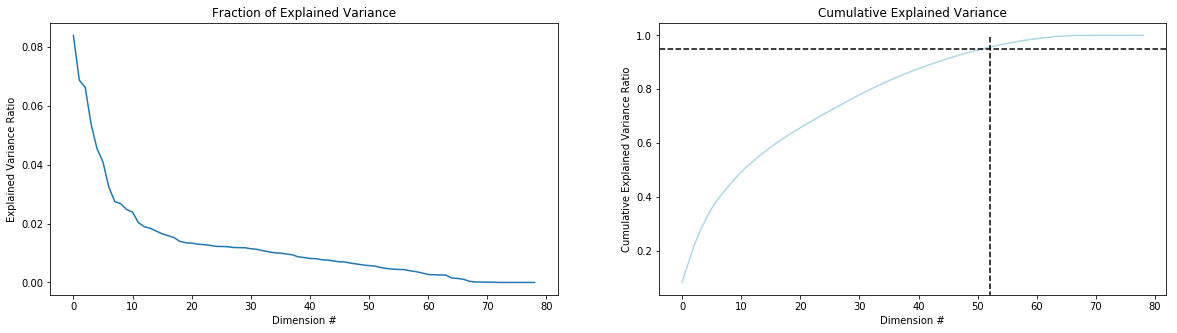

In [16]:
pca_naive = PCA(n_components=None)
pca_naive.fit(x_train)
f, ax = plt.subplots(1,2,figsize=(20,5))
plot_naive_variance(pca_naive, ax[0])
num_pc = plot_pca_var_cum(pca_naive, ax=ax[1], cutoff=0.95)

In [17]:
# pca = PCA(n_components=num_pc)
pca = PCA(n_components=None)
pca.fit(x_train)
x_train_pca = pca.transform(x_train)
x_test_pca = pca.transform(x_test)

### Prediction

In [28]:
rfr = RandomForestRegressor()
rfr.fit(X=x_train_pca, y=y_train)
y_pred_train = rfr.predict(X=x_train_pca)
y_pred_test = rfr.predict(X=x_test_pca)

d:\softwares\python36\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


In [29]:
mse_train = MSE(y_train, y_pred_train)
mse_test = MSE(y_test, y_pred_test)

rmse_train = mse_train**(1/2)
rmse_test = mse_test**(1/2)

print("Train set RMSE: {:.2f}".format(rmse_train))
print("Test set RMSE: {:.2f}".format(rmse_test))

Train set RMSE: 25.63
Test set RMSE: 59.24


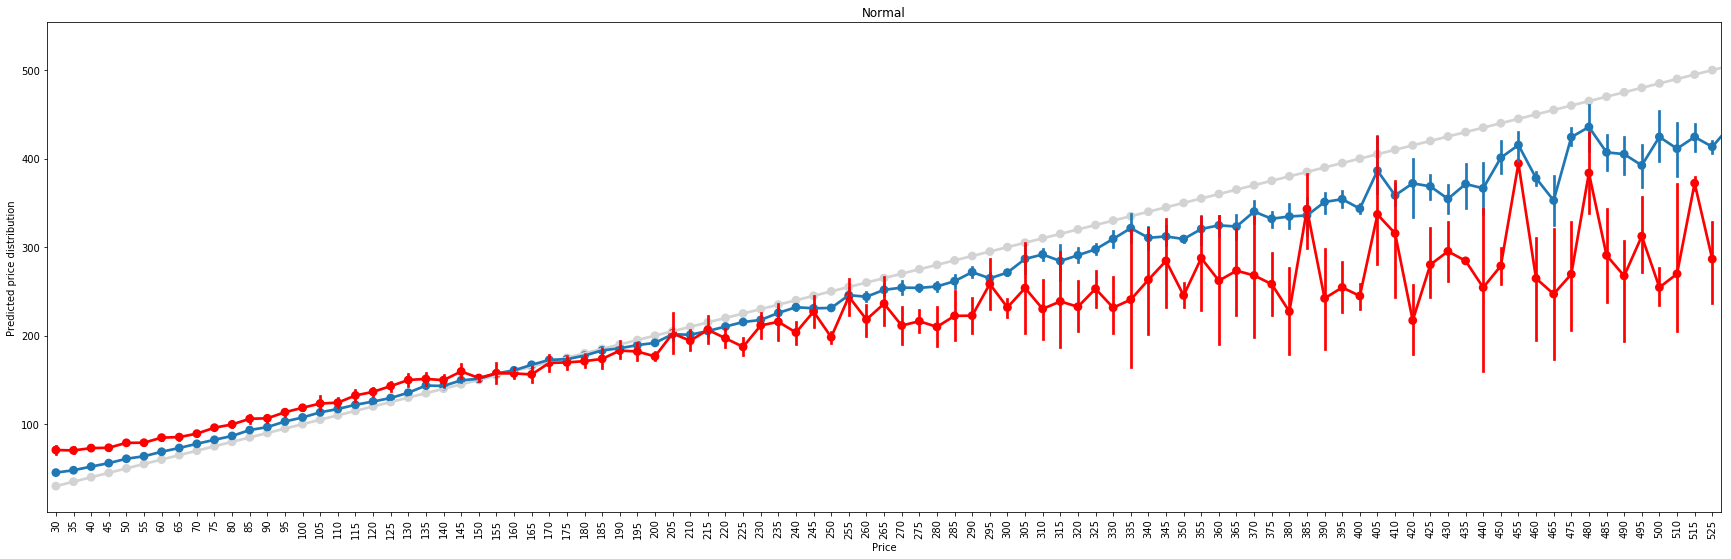

In [30]:
f, ax = plt.subplots(1,1, figsize=(30, 9))
g = sns.pointplot(x=np.unique(y_train), y=np.unique(y_train), color="lightgrey", ax=ax, linestyle="--")
g = sns.pointplot(x=y_train.ravel(), y=y_pred_train.ravel(), ax=ax)
g = sns.pointplot(x=y_test.ravel(), y=y_pred_test.ravel(), ax=ax, color="red")

t = g.set_xlabel("Price")
t = g.set_ylabel("Predicted price distribution")
t = g.set_xticklabels(g.get_xticklabels(), rotation=90)
t = g.set_title("Normal")

In [22]:
rfr = RandomForestRegressor()
rfr.fit(X=x_train, y=y_train)
y_pred_train = rfr.predict(X=x_train)
y_pred_test = rfr.predict(X=x_test)

d:\softwares\python36\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


In [23]:
mse_train = MSE(y_train, y_pred_train)
mse_test = MSE(y_test, y_pred_test)

rmse_train = mse_train**(1/2)
rmse_test = mse_test**(1/2)

print("Train set RMSE: {:.2f}".format(rmse_train))
print("Test set RMSE: {:.2f}".format(rmse_test))

Train set RMSE: 24.01
Test set RMSE: 55.09


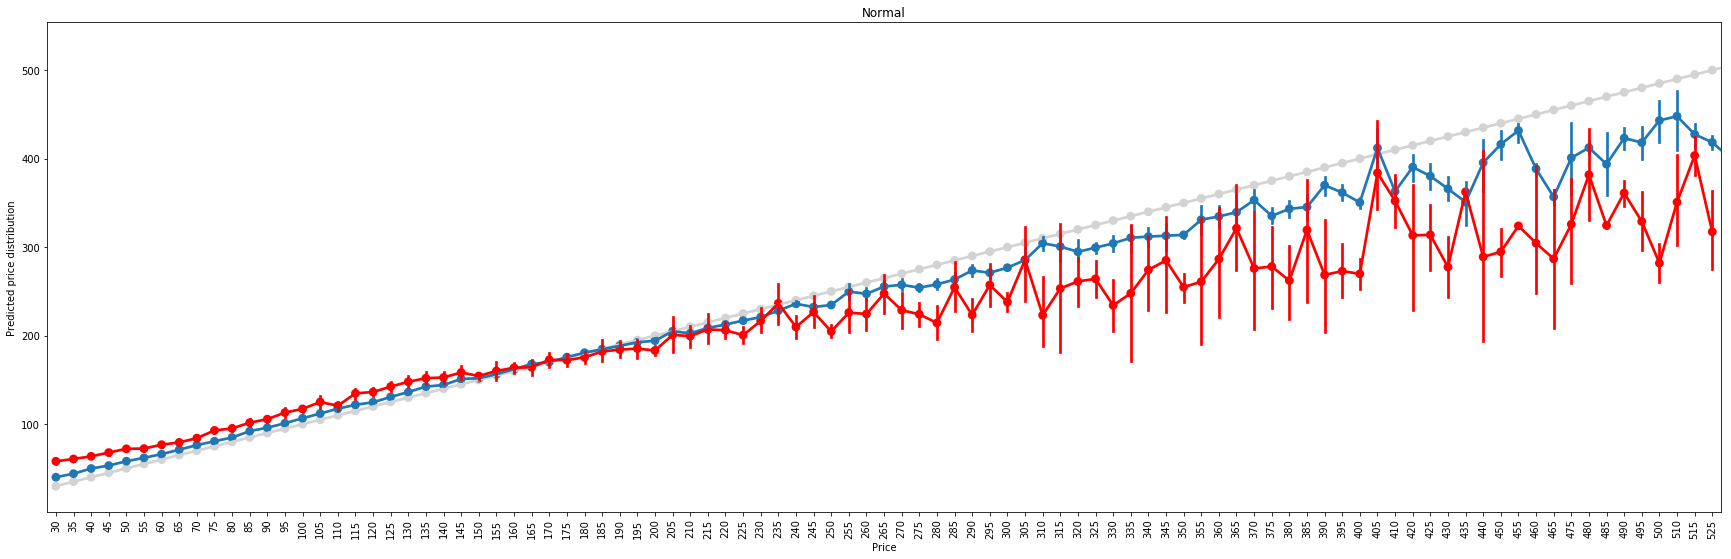

In [27]:
f, ax = plt.subplots(1,1, figsize=(30, 9))
g = sns.pointplot(x=np.unique(y_train), y=np.unique(y_train), color="lightgrey", ax=ax, linestyle="--")
g = sns.pointplot(x=y_train.ravel(), y=y_pred_train.ravel(), ax=ax)
g = sns.pointplot(x=y_test.ravel(), y=y_pred_test.ravel(), ax=ax, color="red")

t = g.set_xlabel("Price")
t = g.set_ylabel("Predicted price distribution")
t = g.set_xticklabels(g.get_xticklabels(), rotation=90)
t = g.set_title("Normal")

# Post Mortem analysis

What causes values beyond 250$ to not perform well for the random forest?

Let's get a count plot of all the bins we made

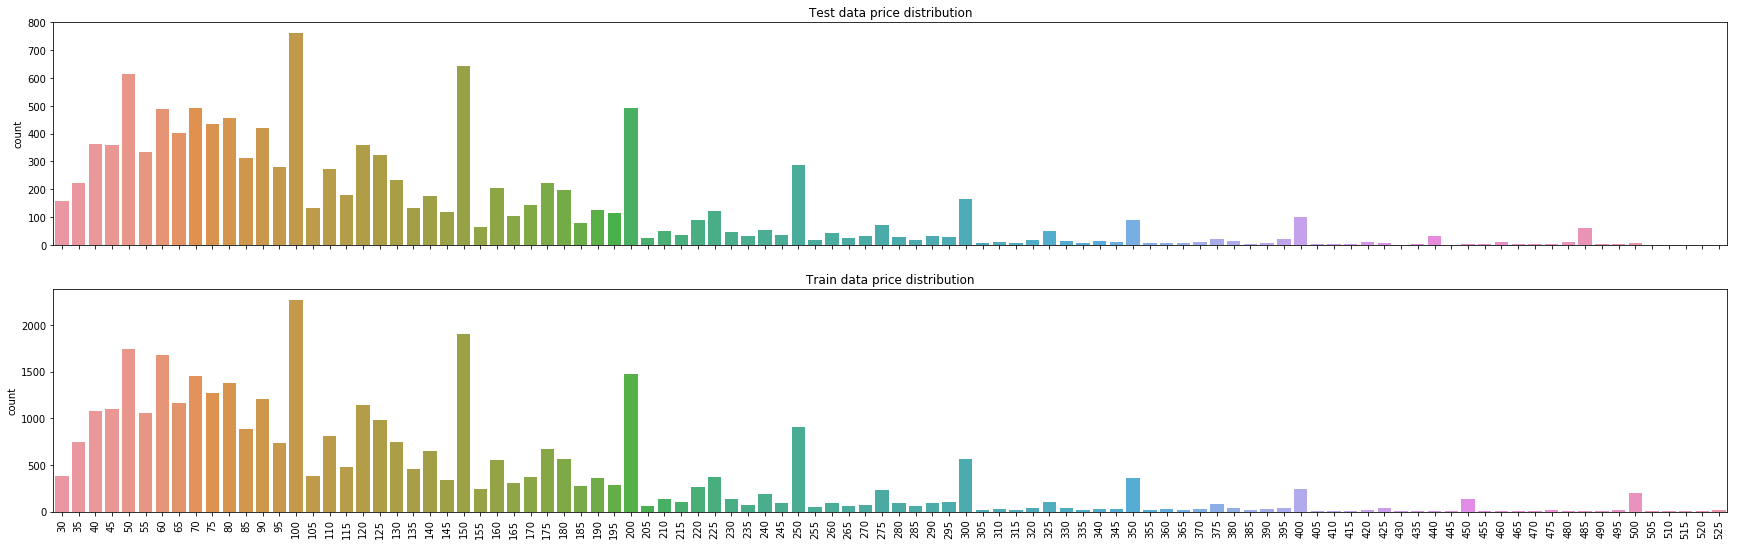

In [25]:
f, ax = plt.subplots(2, 1, figsize=(30,9), sharex=True)
g = sns.countplot(x=y_test.ravel(), ax=ax[0])
t = g.set_xticklabels(g.get_xticklabels(), rotation=90)
t = g.set_title("Test data price distribution")

g = sns.countplot(x=y_train.ravel(), ax=ax[1])
t = g.set_xticklabels(g.get_xticklabels(), rotation=90)
t = g.set_title("Train data price distribution")

Can we compensate for the lack of data points to even out the price distributions everywhere?

In [26]:
tmp = listings_filtered["price"].value_counts().to_frame()
tmp.reset_index(drop=False, inplace=True)
tmp.columns = ["price", "count"]
tmp.sort_values(by="price", inplace=True)
tmp.reset_index(drop=True, inplace=True)

NameError: name 'listings_filtered' is not defined

In [ ]:
tmp["count"].median()

In [ ]:
f, ax = plt.subplots(1, 1, figsize=(30,9))
plot_bar(x="price", y="count", data=tmp, ax=ax, xrot=90, legend=True, annot=False, plot_percentiles=[50, 75],
        title="Price distributions", xlabel="price", ylabel="num_rows")

We may need to generate synthetic samples for the imbalanced bins, thereby ensuring the classifier does not get biased towards the lower values. 

------------------

# Synthetic sample generation

First we identify what we consider as an under-represented sample. Make a separate column that decides that (binary flag column)

In [ ]:
th = tmp["count"].mean()
th=200
def is_under_represented(row):
    if row < th:
        return 1
    return 0
tmp["flag_ur"] = tmp["count"].apply(is_under_represented)

In [ ]:
f, ax = plt.subplots(1, 1, figsize=(30,9))
plot_bar(x="price", y="count", hue="flag_ur", data=tmp, 
         ax=ax, highlight_max_min=False, annot=False, xrot=90)

In [163]:
listings = pd.read_csv(data_path, index_col="id")

percentiles = list(range(0,101))
price_percentile = {}
for p in percentiles:
    price_percentile[p] = np.percentile(listings['price'].values, p)

price_percentile = pd.DataFrame.from_dict(price_percentile, orient='index')

listings_filtered = listings[listings["price"] <= price_percentile.iloc[PERCENTILE_CROP[1],:].values[0]]
listings_filtered = listings_filtered[listings_filtered["price"] >= price_percentile.iloc[PERCENTILE_CROP[0],:].values[0]]

In [164]:
display(
    price_percentile.iloc[PERCENTILE_CROP[0],:].values[0],
    price_percentile.iloc[PERCENTILE_CROP[1],:].values[0]
)

30.0

799.0

### 1. Train test split

In [165]:
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=RANDOM_SEED)
train, test = train_test_split(listings_filtered, test_size=0.2)

### 2. Oversampling using SMOTE

In [166]:
def check_rep(row):
    if (row <= 200) | (row==250) | (row==350) | (row==450) | (row==550) :
        return 0
    elif (row > 200) & (row < 300) & (row != 250):
        return 1 
    elif (row > 300) & (row < 400) & (row != 350):
        return 2 
    elif (row > 400) & (row < 500) & (row != 450):
        return 3 
    else:
        return 4 
    
# def check_rep(row):
#     if row%50 == 0:
#         return 0
#     elif row <= 250:
#         return 0
#     else:
#         return 1

train["flag_ur"] = train["price"].apply(check_rep)

In [167]:
vcs = train["flag_ur"].value_counts()
vcs

0    34379
1     2770
4     1210
2      772
3      264
Name: flag_ur, dtype: int64

In [168]:
ycol = ["flag_ur"]
xcol = [i for i in train.columns if i not in ycol]

x = train[xcol].values
y = train[ycol].values

smote_sampling_strategy = {
    1: int(vcs[1]*4)
    ,2: int(vcs[1]*2)
    ,3: int(vcs[1]*2)
    ,4: int(vcs[1]*2)
}
sm = SMOTE(random_state=RANDOM_SEED, sampling_strategy=smote_sampling_strategy, n_jobs=-1)

x_new, y_new = sm.fit_sample(x, y)

# x_train_rare, x_test_rare, y_train_rare, y_test_rare = train_test_split(x, y, test_size=0.25, random_state=RANDOM_SEED)
# x_new, y_new = sm.fit_sample(x_train_rare, y_train_rare)

In [169]:
# Drop the flag column
train.drop(labels=["flag_ur"], axis=1, inplace=True)

In [170]:
# Get the index of the price columns
def get_index(vallist, val):
    return vallist.index(val)

price_index = get_index(list(train.columns), "price")

In [171]:
y = x_new[:, price_index]
x_train = np.delete(x_new, price_index, axis=1)

In [172]:
y_new = []
for elem in y:
    y_new.append(roundto(elem))

y_train = y_new

In [173]:
display(
x_train.shape,
train.shape,
len(y_train)
)

(62079, 79)

(39395, 80)

62079

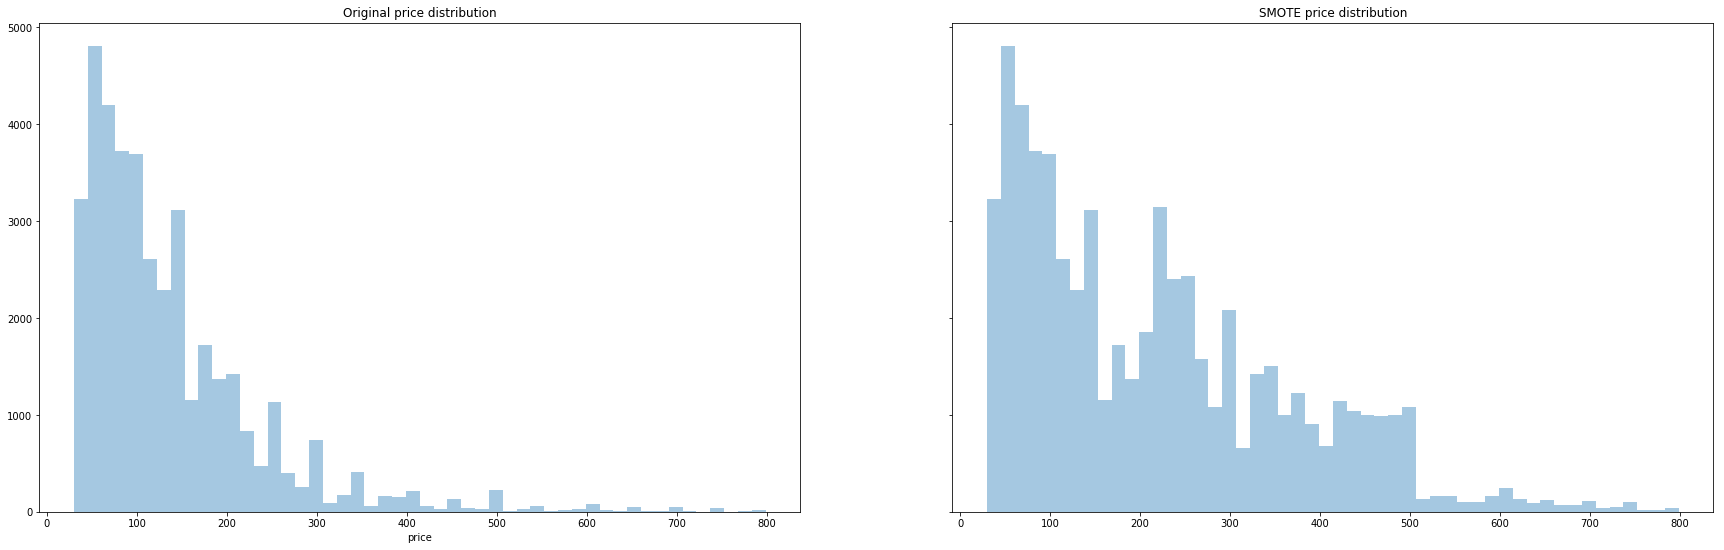

In [174]:
f, ax = plt.subplots(1, 2, figsize=(30, 9), sharey=True)
g1 = sns.distplot(train["price"], ax=ax[0], kde=False)
t = g1.set_title("Original price distribution")

g2 = sns.distplot(y, ax=ax[1], kde=False)
t = g2.set_title("SMOTE price distribution")


### 3. Standardisation

In [175]:
standard_scaler = StandardScaler()
x_train = standard_scaler.fit_transform(x_train)

In [176]:
# Get the index of the price columns
def get_index(vallist, val):
    return vallist.index(val)

price_index = get_index(list(test.columns), "price")

x_tmp = test.values
y_test = x_tmp[:, price_index]
x_test = np.delete(x_tmp, price_index, axis=1)

y_tmp = []
for elem in y_test:
    y_tmp.append(roundto(elem))

y_test = y_tmp

x_test = standard_scaler.transform(x_test)

display(
    train.shape,
    x_train.shape,
    len(y_train),
    test.shape,
    x_test.shape,
    len(y_test)
)

(39395, 80)

(62079, 79)

62079

(9849, 80)

(9849, 79)

9849

### 4. Transformation

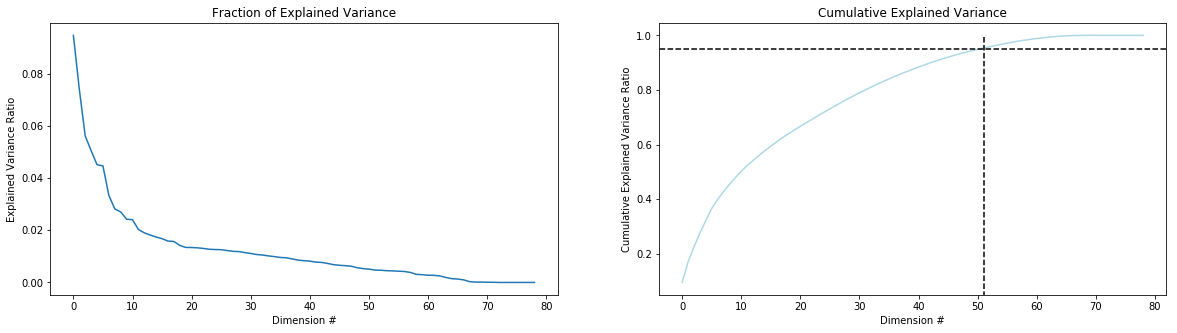

In [177]:
pca_naive = PCA(n_components=None)
pca_naive.fit(x_train)
f, ax = plt.subplots(1,2,figsize=(20,5))
plot_naive_variance(pca_naive, ax[0])
num_pc = plot_pca_var_cum(pca_naive, ax=ax[1], cutoff=0.95)

In [178]:
# pca = PCA(n_components=num_pc)
pca = PCA(n_components=None)
pca.fit(x_train)
x_train_pca = pca.transform(x_train)
x_test_pca = pca.transform(x_test)

### Prediction

##### Random Forest Regressor

In [179]:
rfr = RandomForestRegressor()
rfr.fit(X=x_train_pca, y=y_train)
y_pred_train = rfr.predict(X=x_train_pca)
y_pred_test = rfr.predict(X=x_test_pca)

In [180]:
mse_train = MSE(y_train, y_pred_train)
mse_test = MSE(y_test, y_pred_test)

rmse_train = mse_train**(1/2)
rmse_test = mse_test**(1/2)

print("Train set RMSE: {:.2f}".format(rmse_train))
print("Test set RMSE: {:.2f}".format(rmse_test))

Train set RMSE: 29.66
Test set RMSE: 75.28


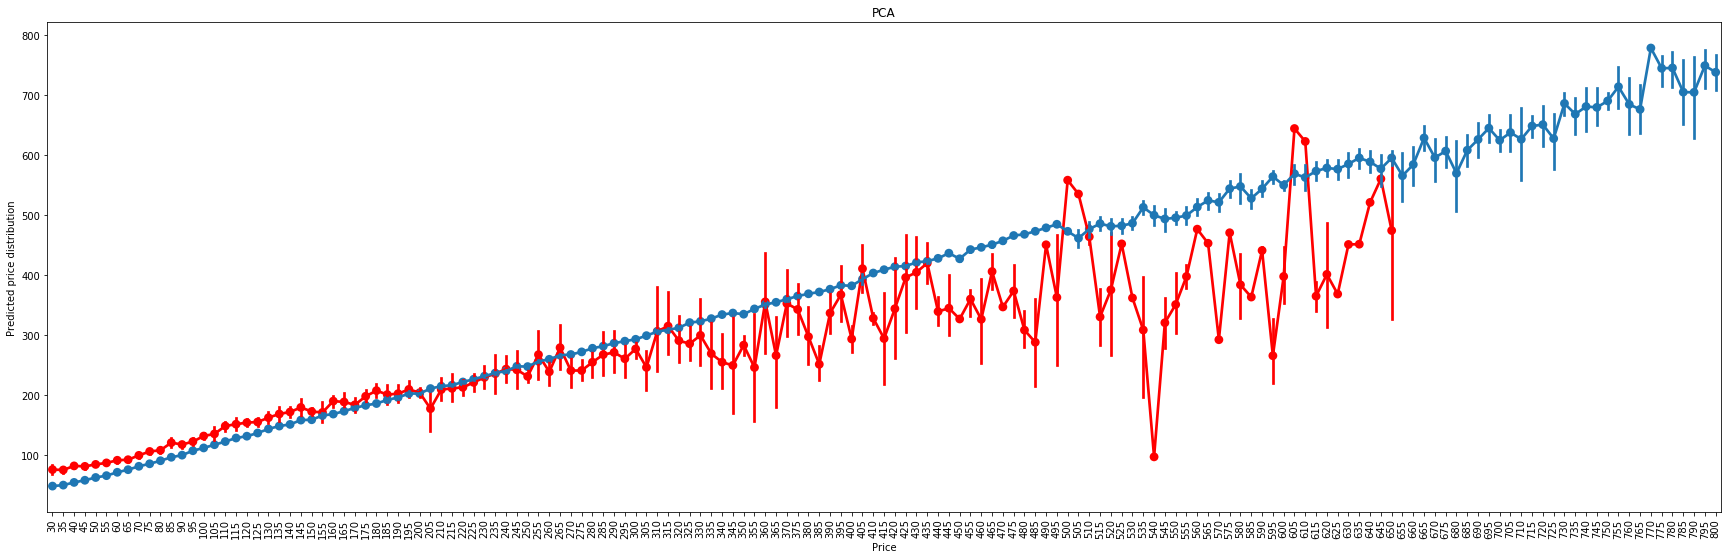

In [181]:
f, ax = plt.subplots(1,1, figsize=(30, 9))
g = sns.pointplot(x=y_test, y=y_pred_test, ax=ax, color="red")
g = sns.pointplot(x=y_train, y=y_pred_train, ax=ax)

t = g.set_xlabel("Price")
t = g.set_ylabel("Predicted price distribution")
t = g.set_xticklabels(g.get_xticklabels(), rotation=90)
t = g.set_title("PCA")

In [182]:
rfr = RandomForestRegressor()
rfr.fit(X=x_train, y=y_train)
y_pred_train = rfr.predict(X=x_train)
y_pred_test = rfr.predict(X=x_test)

In [183]:
mse_train = MSE(y_train, y_pred_train)
mse_test = MSE(y_test, y_pred_test)

rmse_train = mse_train**(1/2)
rmse_test = mse_test**(1/2)

print("Train set RMSE: {:.2f}".format(rmse_train))
print("Test set RMSE: {:.2f}".format(rmse_test))

Train set RMSE: 26.38
Test set RMSE: 66.44


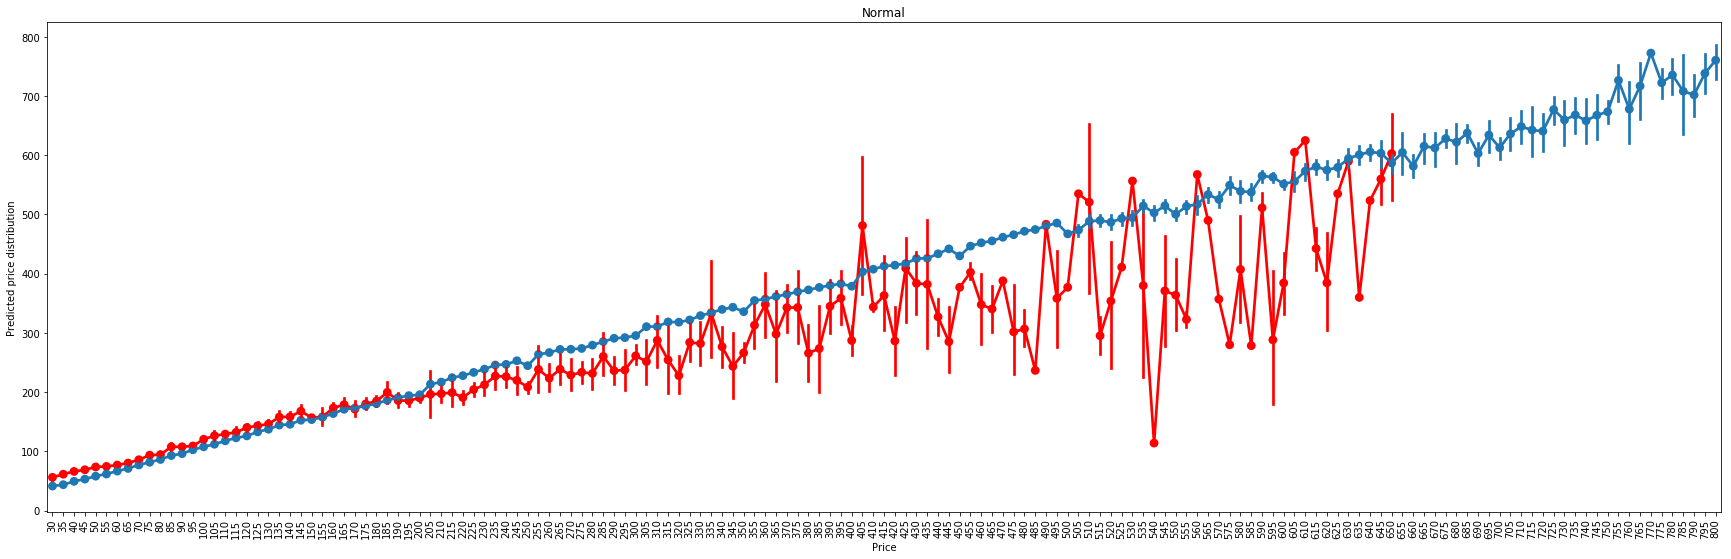

In [187]:
f, ax = plt.subplots(1,1, figsize=(30, 9))
g = sns.pointplot(x=y_test, y=y_pred_test, ax=ax, color="red")
g = sns.pointplot(x=y_train, y=y_pred_train, ax=ax)

t = g.set_xlabel("Price")
t = g.set_ylabel("Predicted price distribution")
t = g.set_xticklabels(g.get_xticklabels(), rotation=90)
t = g.set_title("Normal")

In [185]:
max(y_test)

800

##### Gradient boosting regressor

In [94]:
gbr = GradientBoostingRegressor(n_estimators=100)
gbr.fit(X=x_train, y=y_train)
y_pred_train = abr.predict(X=x_train)
y_pred_test = abr.predict(X=x_test)

In [95]:
mse_train = MSE(y_train, y_pred_train)
mse_test = MSE(y_test, y_pred_test)

rmse_train = mse_train**(1/2)
rmse_test = mse_test**(1/2)

print("Train set RMSE: {:.2f}".format(rmse_train))
print("Test set RMSE: {:.2f}".format(rmse_test))

Train set RMSE: 100.41
Test set RMSE: 107.58


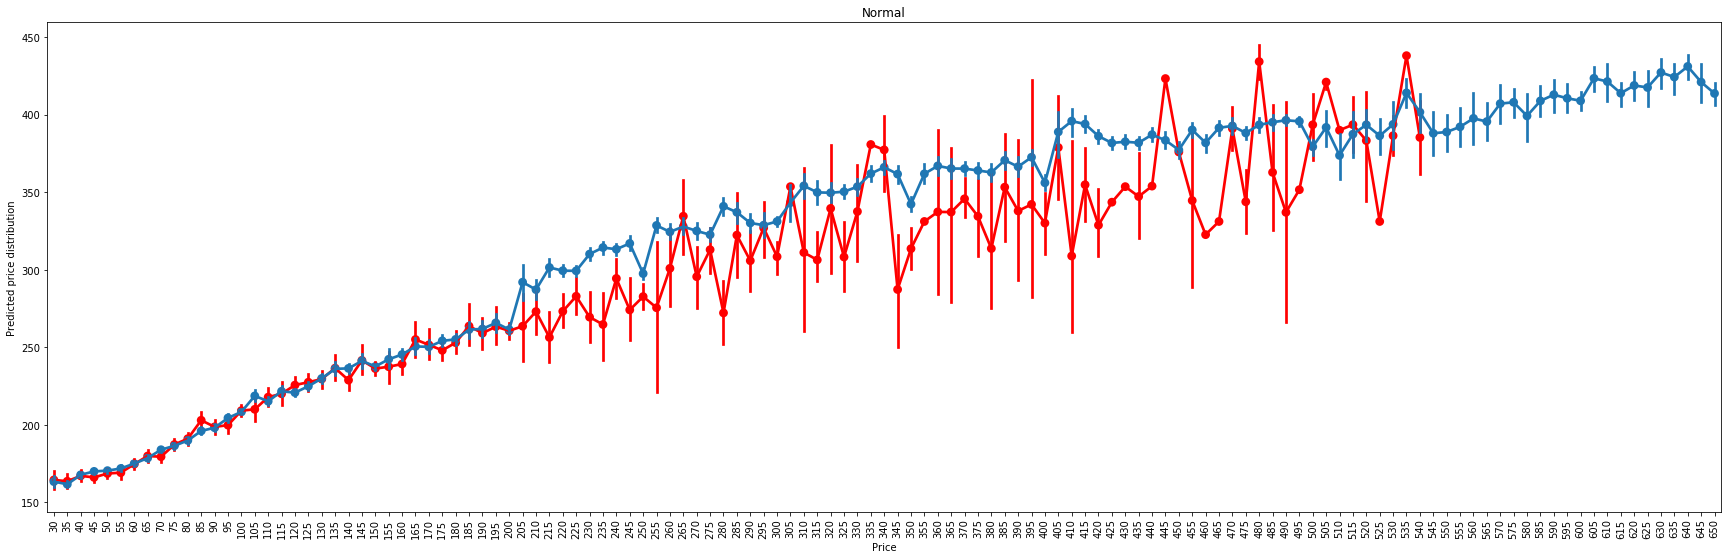

In [96]:
f, ax = plt.subplots(1,1, figsize=(30, 9))
g = sns.pointplot(x=y_test, y=y_pred_test, ax=ax, color="red")
g = sns.pointplot(x=y_train, y=y_pred_train, ax=ax)

t = g.set_xlabel("Price")
t = g.set_ylabel("Predicted price distribution")
t = g.set_xticklabels(g.get_xticklabels(), rotation=90)
t = g.set_title("Normal")

### Grid Search

##### Random Forest

In [ ]:
rfr = RandomForestRegressor()

# Instantiate the GridSearchCV object and run the search
parameters = {
                'criterion':['mse', 'mae'],
                'n_estimators':[50, 100],
                'max_features':['auto','sqrt','log2',None],
                'random_state':[42]
             }
searcher = GridSearchCV(rfr, parameters)
searcher.fit(x_train, y_train)

# Report the best parameters
print("Best CV params", searcher.best_params_)

In [ ]:
abr = AdaBoostRegressor()

# Instantiate the GridSearchCV object and run the search
parameters = {
                'learning_rate':[2, 1, 0.5, 0.3, 0.2],
                'n_estimators':[50, 100],
                'loss':['linear', 'square', 'exponential'],
                'random_state':[42]
             }
searcher = GridSearchCV(abr, parameters)
searcher.fit(x_train, y_train)

# Report the best parameters
print("Best CV params", searcher.best_params_)

In [ ]:
gbr = GradientBoostingRegressor()

# Instantiate the GridSearchCV object and run the search
parameters = {
                'learning_rate':[2, 1, 0.5, 0.3, 0.2],
                'n_estimators':[50, 100],
                'loss':['ls', 'lad', 'huber', 'quantile'],
                'random_state':[42],
                'min_samples_split': [2, 4, 6, 8],
                'min_samples_leaf': [1, 2, 4, 6]
             }
searcher = GridSearchCV(gbr, parameters)
searcher.fit(x_train, y_train)

# Report the best parameters
print("Best CV params", searcher.best_params_)

# Post Mortem analysis

What causes values beyond 250$ to not perform well for the random forest?

Let's get a count plot of all the bins we made

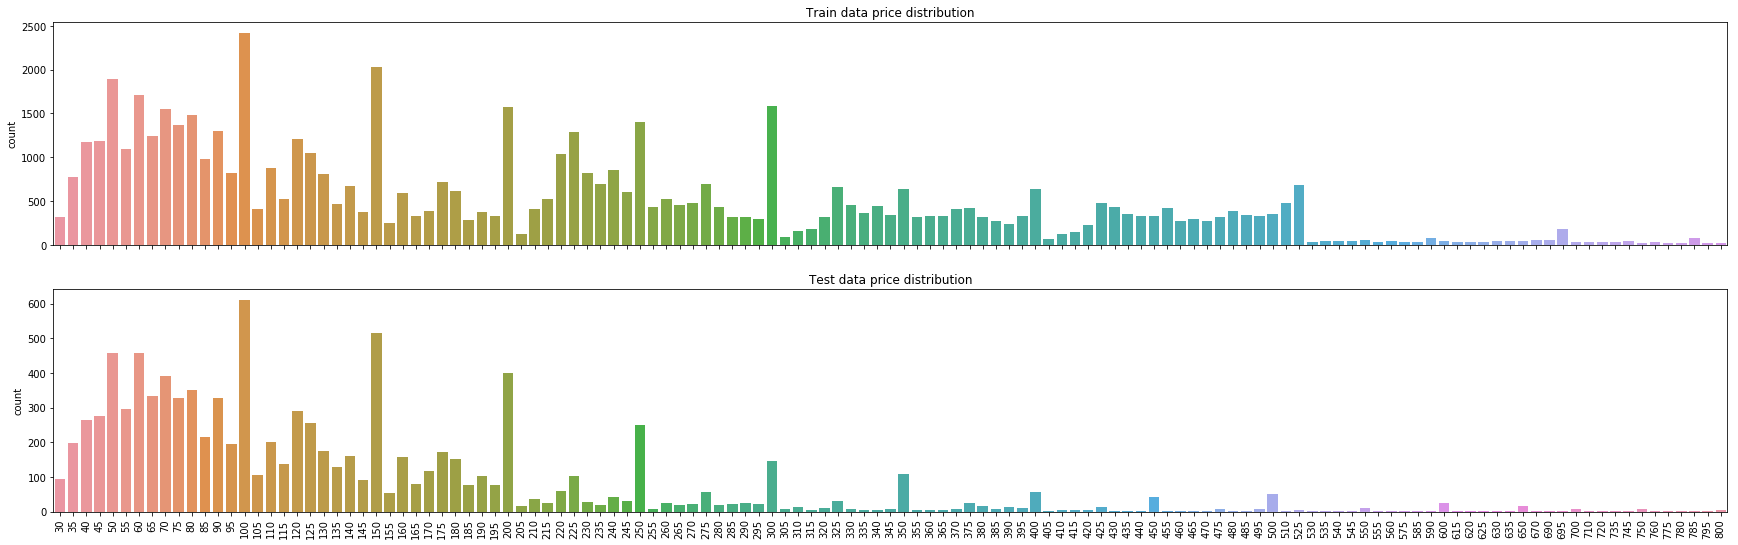

In [61]:
f, ax = plt.subplots(2, 1, figsize=(30,9), sharex=True)

g = sns.countplot(x=y_train, ax=ax[0])
t = g.set_xticklabels(g.get_xticklabels(), rotation=90)
t = g.set_title("Train data price distribution")

g = sns.countplot(x=y_test, ax=ax[1])
t = g.set_xticklabels(g.get_xticklabels(), rotation=90)
t = g.set_title("Test data price distribution")
